<a href="https://colab.research.google.com/github/digital-science/dimensions-api-lab/blob/master/3-workshops/2019-04-Technical-University-of-Denmark/6-Citation-Graph-example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open Dimensions API Lab In Google Colab"/></a>

# How to use the Dimensions DSL to build a citation graph

This notebook will demonstrate how to build a citation graph like the one below

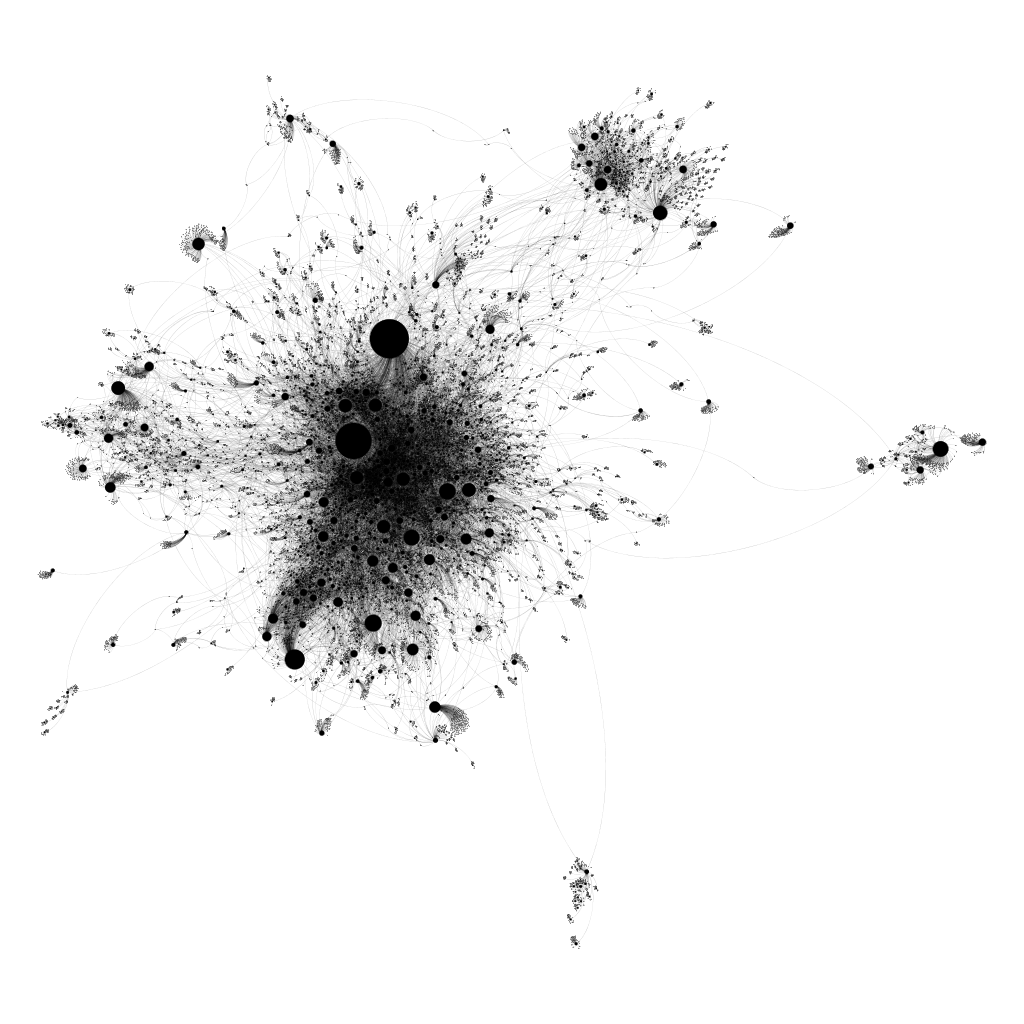

In [1]:
from IPython.display import Image
#Process the graphml file in Gephi and you will get something like this
Image(filename='Chaomei20063degree.png', height=500, width=500) 

In [2]:
from dimcli.shortcuts import dslquery_json as dslquery
from collections import Counter
import networkx as nx


## 1)  Seed your citation graph
Define a function that will give you back the publications that you want to start your citation graph from

In [3]:
def searchPubs(limit=1000, skip=0):
    data = """search publications 
          where id="pub.1001131784"
          return publications[id+times_cited+year]
          limit {} skip {}
    """.format(limit,skip)
    return data

def dslsearchpublications():
    skip = 0
    pubs = []
    total_pubs = []
    result = {}
    while (skip == 0) or (len(pubs) == 1000):
        pubs = dslquery(searchPubs(skip=skip),0).get('publications',[])
        total_pubs += pubs
        skip += 1000 
    return total_pubs

## 2) Get the citing papers
Define a function that returns the details that you need about the citing papers

In [4]:
def citedpublications(ids,limit=1000,skip=0):
    data = """search publications
                  where (references in [{}])
              return publications[id+year+references] sort by id
                  limit {} skip {}
    """.format(','.join(['"{}"'.format(id) for id in ids]),limit,skip)
    print(skip)
    return data

## 3) Process the citing papers and get a 1 degree ciation graph
For the set of papers that you are interested in, process the citing papers to extract the relevant 1d citation graph, partitoned by year

In [5]:
def dslsearchcitedpublications(cited_ids,citationGraph=nx.Graph()):
    
    idchunks = [cited_ids[x:x + 500] for x in range(0, len(cited_ids), 500)]
    result = {}
    years = {}
    
    total_pubs = []
    for idc in idchunks:        
        skip = 0
        pubs = []        
        while skip == 0 or len(pubs)== 1000:
            pubs = dslquery(citedpublications(idc, skip=skip),0).get('publications',[])
            total_pubs += pubs
            skip += 1000   
    
    for i, p in enumerate(total_pubs):

        rs= []
        
        for r in p['references']:
            try:
                rs.append(r)
            except:
                print("found this anomalous data {}".format(r))
                
        references_set = set(rs)
        
        focusedcites = list(references_set - set(references_set - set(cited_ids)))

        citationGraph.add_edges_from([(p['id'],f,{'year':p.get('year','no_year')}) for f in focusedcites])
 
    return citationGraph

## 4) Walk the graph n times
Get second and third order citations by running dslsearchcitedpublications over the output of the previous run

In [ ]:
result = {}
result_list = []
pubs = dslsearchpublications()  # Step 1
iteration = 0

pubs = [p['id'] for p in pubs]

while iteration < 3:
    iteration += 1

    cg = dslsearchcitedpublications([p for p in pubs])
    
    result_list.append(dict(citationGraph=cg))
    
    # Get the next iteration of publications from the publication graph
    pubs = [ e[1] for e in cg.edges()]

    
citationGraph = nx.Graph()

all_edges = [a for r in result_list for a in list(r['citationGraph'].edges())]
    
citationGraph.add_edges_from(all_edges)
    


In [7]:
#Export citation graph
nx.write_graphml(citationGraph, "citationGraphChaomei2006test.graphml")

## Finally load the output into gephi to process your output

https://gephi.org/users/download/

---
# Want to learn more?

Check out the [Dimensions API Lab](https://digital-science.github.io/dimensions-api-lab/) website, which contains many tutorials and reusable Jupyter notebooks for scholarly data analytics. 